In [5]:
import sys
sys.path.append("../")

from src.cmesrc.config import CMESRCV3_DB
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
COLOR = "#231F20"
plt.rcParams["font.family"] = "Ubuntu"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 32
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams["axes.labelweight"] = "bold"

cm_to_inch = 0.393701

In [6]:
conn = sqlite3.connect(CMESRCV3_DB)
cur = conn.cursor()

In [7]:
matches = pd.read_sql("""
SELECT * FROM FINAL_CME_HARP_ASSOCIATIONS FCHA
INNER JOIN CMES C
ON FCHA.CME_ID = C.CME_ID                    
""", conn)
tot_cmes = pd.read_sql("""
SELECT * FROM CMES
""", conn)

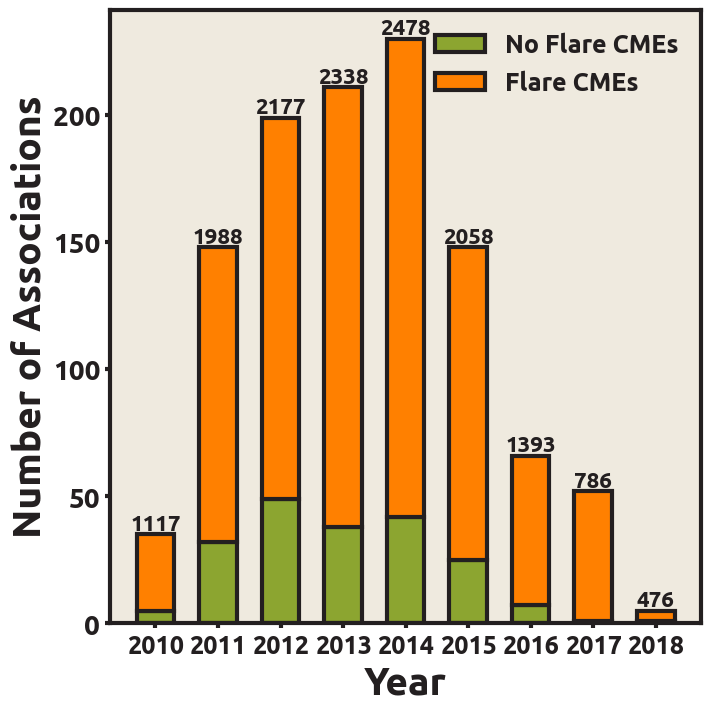

In [11]:
# Required library for color manipulation
import matplotlib.colors as mcolors

# Now let's plot the number of associations per year in bins of 1 year

# First we need to convert the date to a datetime object
matches['date'] = pd.to_datetime(matches['cme_date'])
matches['year'] = matches['date'].dt.year

tot_cmes['date'] = pd.to_datetime(tot_cmes['cme_date'])
tot_cmes['year'] = tot_cmes['date'].dt.year

# Count the total CMEs per year
tot_cmes_counts = tot_cmes.groupby('year').size()

no_flare_matches = matches[matches["verification_score"] == 5]
flare_matches = matches[matches["verification_score"] != 5]

first_year = matches['year'].min()
last_year = matches['year'].max()

# Count the matches for each year
no_flare_counts = no_flare_matches.groupby('year').size()
flare_counts = flare_matches.groupby('year').size()

# Prepare the range for the x-axis
years = range(first_year, last_year + 1)

# Define a good color for flare bars that stands out, but is in harmony with the existing color scheme
flare_color = mcolors.to_hex(plt.cm.autumn(0.5))  # Example color

# Now we can plot the histogram
fig, ax = plt.subplots(figsize=(20 * cm_to_inch, 20 * cm_to_inch))

# Get counts for each group per year
no_flare_heights = [no_flare_counts.get(year, 0) for year in years]
flare_heights = [flare_counts.get(year, 0) for year in years]

WIDTH = 0.6

# Plot no flare bars
ax.bar(years, no_flare_heights, color='#8CA530', edgecolor='#231F20', align='center', width=WIDTH, label='No Flare CMEs', linewidth=3)

# Plot flare bars on top
ax.bar(years, flare_heights, bottom=no_flare_heights, color=flare_color, edgecolor='#231F20', align='center', width=WIDTH, label='Flare CMEs', linewidth=3)

# Now, add the total counts above the bars
for year, nf_height, f_height in zip(years, no_flare_heights, flare_heights):
    total_height = nf_height + f_height  # This will be the top of the stacked bar
    # Get the total CME count for the year
    if year in tot_cmes_counts:
        total_cmes = tot_cmes_counts[year]
        # Place the text above the combined bar height
        ax.text(year, total_height, str(total_cmes), ha='center', va='bottom', fontsize=16, color='#231F20')

# Configure and style the plot (ticks, labels, spines)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.set_xlabel('Year', fontsize=28)
ax.set_ylabel('Number of Associations', fontsize=28)
ax.set_facecolor('#EFEADF')
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('#231F20')
ax.set_xticks(years)
ax.tick_params(width=3)
ax.tick_params(axis='both', colors='#231F20')

# Define and apply the configuration for the legend
legend_config = {
    'frameon': False,
    'fontsize': 18,
    'loc': 'upper right',
}
ax.legend(**legend_config)

plt.tight_layout()

plt.savefig("/home/julio/Documents/esww/catalogue.pdf", bbox_inches='tight')
plt.savefig("/home/julio/Documents/esww/catalogue.png", dpi=300, bbox_inches='tight', transparent=True)
